In [6]:
import subprocess

# Basic imports
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from pathlib import Path

# Library imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.geospatial import ensure_geometric_CRS
from multiview_mapping_toolkit.config import (
    NULL_TEXTURE_INT_VALUE,
)
from multiview_mapping_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

# Set constants
You should be able to define most of the behavior from these constants

In [7]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
#
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

## Define the inputs
# The input labels
LABELS_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/field_ref/crowns_drone_w_field_data.geojson"

short_model_name = "chips"
long_model_name = "ChipsB"
short_pred_name = "delta"
long_pred_name = "DeltaB"
# The digital elevation map exported by Metashape
DTM_FILE = f"/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/{short_model_name}/02_photogrammetry/exports/dtms/{short_model_name}.tif"
# The image folder used to create the Metashape project
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{long_model_name}"

## Define the intermediate results
LABELED_MESH_FILENAME = f"/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/{short_model_name}/03_training_data/labeled.ply"

# Where to save the rendering label images
RENDER_FOLDER = f"/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/{short_model_name}/03_training_data/renders"

TRAINING_DATA_FOLDER = f"/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/{short_model_name}/03_training_data/{short_model_name}_80m_only_no_ground"
WORK_DIR = f"/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/per_site/{short_model_name}/80_meter_with_ground"


CHIPS_MESH_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/meshes/ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply"
# The camera file exported from Metashape
CHIPS_CAMERAS_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/cameras/ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml"
# The mesh exported from Metashape
DELTA_MESH_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/meshes/DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply"
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/cameras/DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml"

if short_model_name == "chips":
    # The mesh exported from Metashape
    INFERENCE_IMAGE_FOLDER = "/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/DeltaB/DeltaB_80m"
    PREDICTIONS_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_80m_model/DeltaB_80m"
    MESH_FILENAME = CHIPS_MESH_FILENAME
    CAMERAS_FILENAME = CHIPS_CAMERAS_FILENAME
    PREDICTION_MESH_FILENAME = DELTA_MESH_FILENAME
    PREDICTION_CAMERAS_FILENAME = DELTA_CAMERAS_FILENAME
    PREDICTION_DTM_FILE = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/dtms/delta.tif"
    PREDICTED_VECTOR_LABELS_FILE = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/05_processed_predictions/delta_80m_chips_model.geojson"
    NUMPY_EXPORT_FACES_TEXTURE_FILE = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/05_processed_predictions/delta_80m_chips_model.npy"
    
elif short_model_name == "delta":
    INFERENCE_IMAGE_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/images_near_labels/ChipsB_80m_2021_complete"
    PREDICTIONS_FOLDER = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/delta_80m_model/ChipsB_80m_2021_complete"
    MESH_FILENAME = DELTA_MESH_FILENAME
    CAMERAS_FILENAME = DELTA_CAMERAS_FILENAME
    PREDICTION_MESH_FILENAME = CHIPS_MESH_FILENAME
    PREDICTION_CAMERAS_FILENAME = CHIPS_CAMERAS_FILENAME
    PREDICTION_DTM_FILE = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif"

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

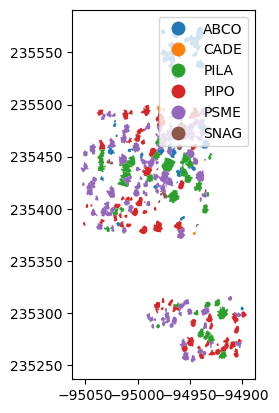

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

gdf.query(f"fire=='{short_model_name}'").plot(
    "species_observed", legend=True, vmin=0, vmax=9
)

# Load the mesh and read texture from geopolygon

In [8]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=BUFFER_RADIUS_METERS,
        texture=LABELS_FILENAME,
        texture_column_name="species_observed",
        transform_filename=CAMERAS_FILENAME,
    )
    # Label the ground class
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="ground",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )
print(mesh.IDs_to_labels)
class_names = mesh.get_label_names()
print(f"class names {class_names}")

Loading transform to EPSG:4326


INFO:multiview_mapping_toolkit.meshes.meshes:Loading transform to EPSG:4326


Loading mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Loading mesh


Reading the mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Reading the mesh


Selecting an ROI from mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Selecting an ROI from mesh


Standardizing ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Standardizing ROI


Dissolving ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Dissolving ROI


Setting CRS and buffering ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Dissolving buffered ROI


Extracting verts for dataframe


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extraction surface from subset mesh


Extracting faces from mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting faces from mesh


Loading texture


INFO:multiview_mapping_toolkit.meshes.meshes:Loading texture


Could not read texture as a scalar from the pyvista mesh


Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif: 100%|██████████| 520337/520337 [00:20<00:00, 25156.42it/s]


{0: 'ABCO', 1: 'CADE', 2: 'PILA', 3: 'PIPO', 4: 'PSME', 5: 'QUEV', 6: 'SNAG', 7: 'ground'}
class names ['ABCO', 'CADE', 'PILA', 'PIPO', 'PSME', 'QUEV', 'SNAG', 'ground']


# Load a set of cameras and downsample them to the region around annotations

Loading GPS data for camera set: 100%|██████████| 25122/25122 [00:00<00:00, 2246297.12it/s]


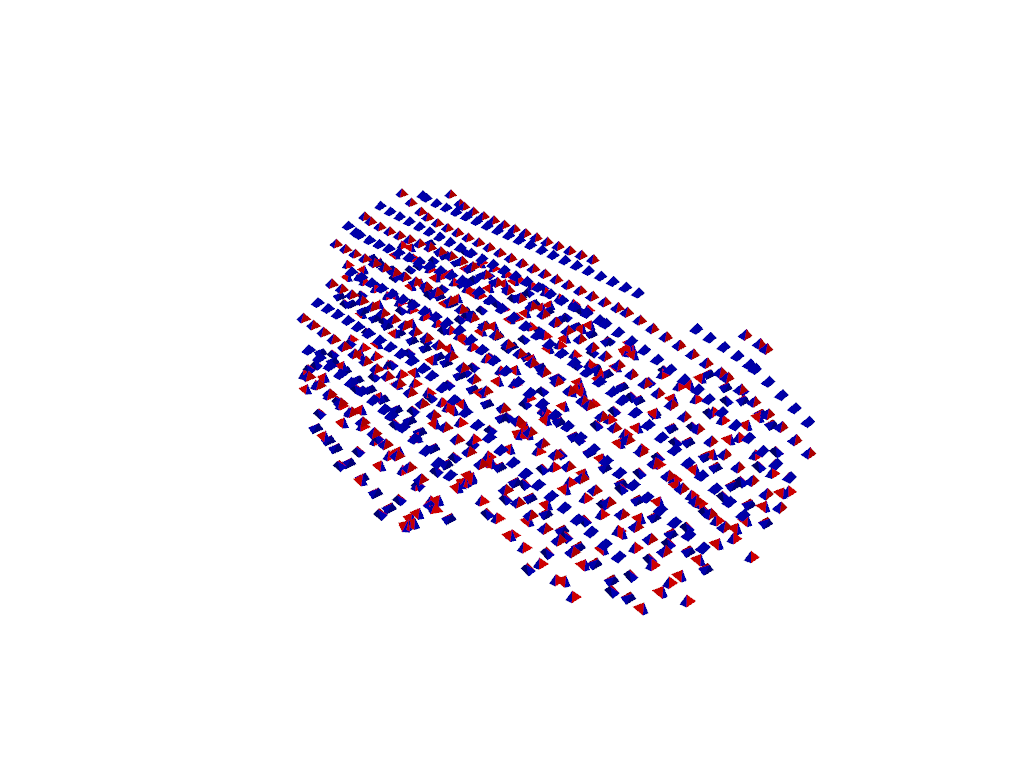

In [5]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Show the mesh

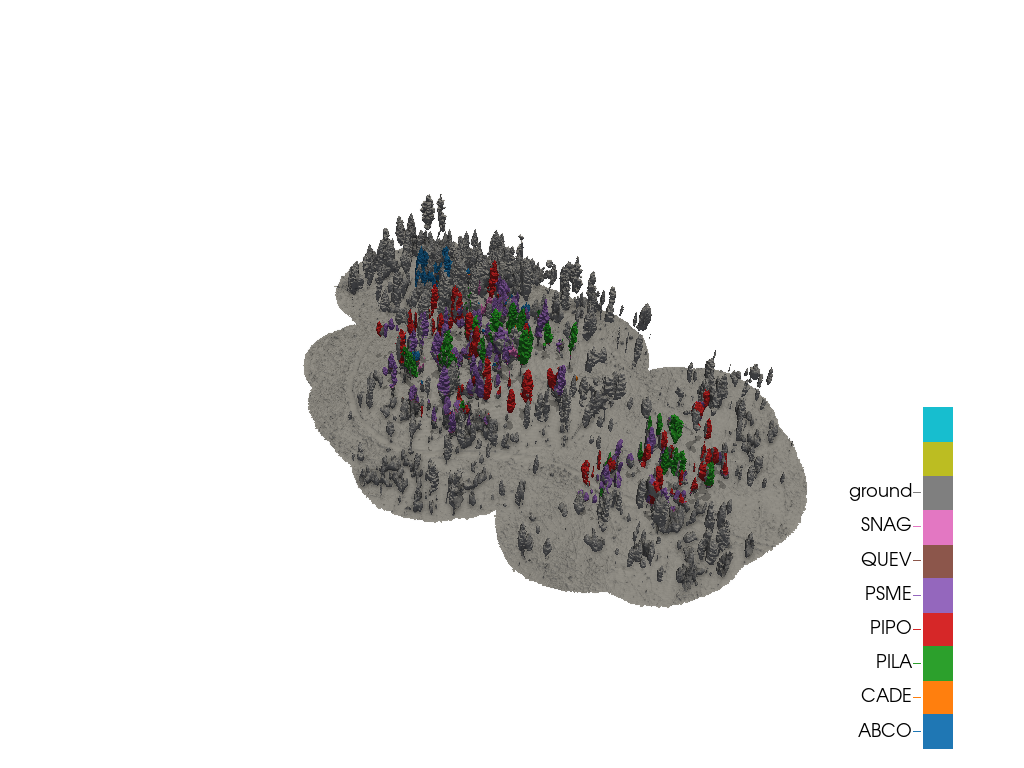

In [6]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [7]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/renders
Saving IDs_to_labels to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/renders/IDs_to_labels.json


Saving renders: 100%|██████████| 797/797 [12:01<00:00,  1.10it/s]


# Show some of the rendered labels

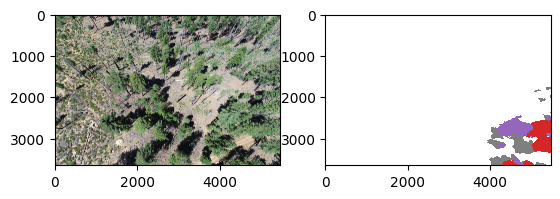

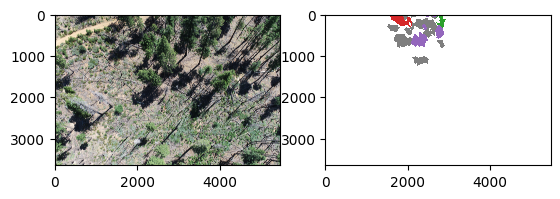

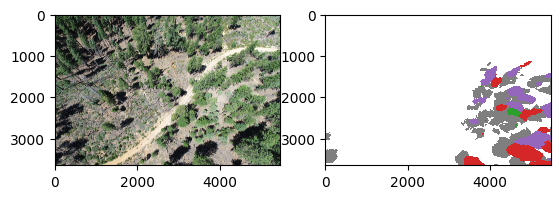

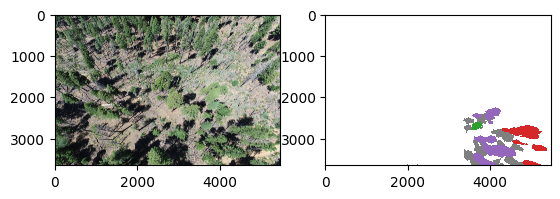

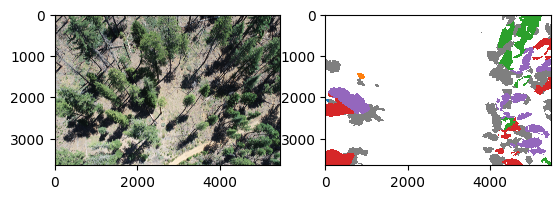

In [8]:
rendered_files = list(Path(RENDER_FOLDER).rglob("*.png"))

for rendered_file in rendered_files[:5]:
    image_file = Path(
        IMAGE_FOLDER, rendered_file.relative_to(RENDER_FOLDER)
    ).with_suffix(".JPG")
    image = imread(image_file)
    render = imread(rendered_file).astype(float)
    render[render == NULL_TEXTURE_INT_VALUE] = np.nan
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(render, vmin=0, vmax=9, cmap="tab10", interpolation="none")
    plt.show()
    plt.close()

# Format the training data

In [9]:
class_names_str = " ".join(class_names)

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {FOLDER_TO_CITYSCAPES_SCRIPT} --images-folder {IMAGE_FOLDER}"
    + f" --labels-folder {RENDER_FOLDER} --output-folder {TRAINING_DATA_FOLDER} --classes {class_names_str} --remove-old",
    shell=True,
)

100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


(3992372, 3)
mean: [107.02620472240562, 116.45520632846839, 98.24730661371235], std: [73.1984646281286, 73.23999060695704, 65.22553687333551]
About to save config to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/chips_80m_only_no_ground.py


visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train: 100%|██████████| 30/30 [01:05<00:00,  2.19s/it]
visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/val: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py --images-folder /ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/ChipsB --labels-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/renders --output-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground --classes ABCO CADE PILA PIPO PSME QUEV SNAG ground --remove-old', returncode=0)

# Show some of the formatted example images

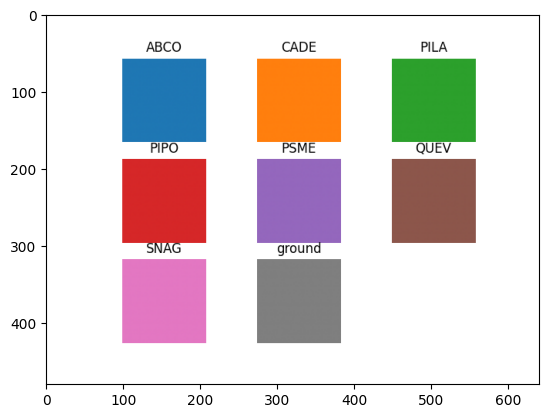

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/val/ChipsB_120m_PART_02_100MEDIA_DJI_0984_rgb.JPG


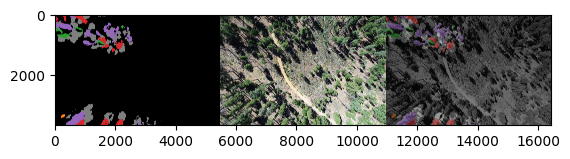

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_120m_PART_02_101MEDIA_DJI_0961_rgb.JPG


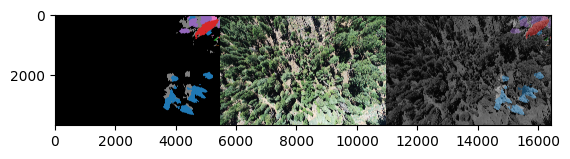

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_80m_2021_complete_SD_card_25_104MEDIA_DJI_0070_rgb.JPG


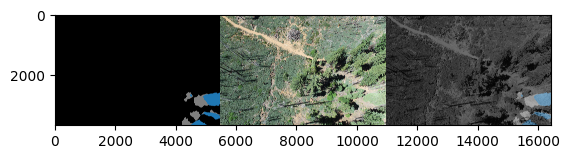

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_120m_PART_02_100MEDIA_DJI_0715_rgb.JPG


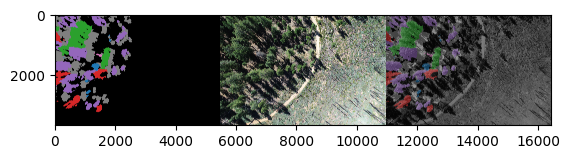

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0277_rgb.JPG


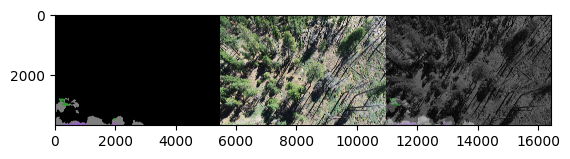

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/val/ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0637_rgb.JPG


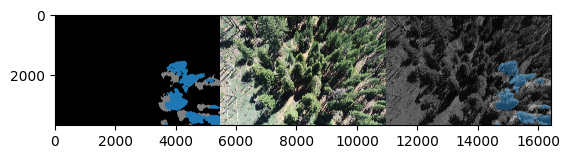

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_80m_2021_complete_SD_card_25_104MEDIA_DJI_0138_rgb.JPG


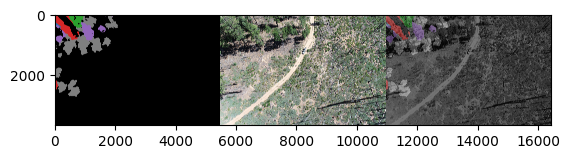

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0932_rgb.JPG


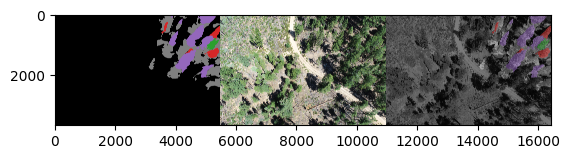

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_120m_PART_02_101MEDIA_DJI_0908_rgb.JPG


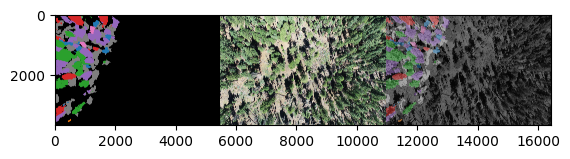

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/vis/train/ChipsB_80m_2021_complete_SD_card_25_104MEDIA_DJI_0070_rgb.JPG


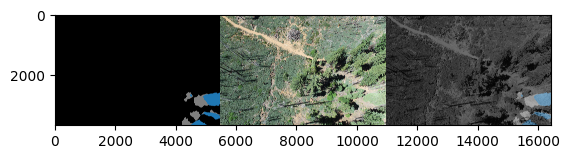

In [10]:
cmap_file = Path(TRAINING_DATA_FOLDER, "colormap.png")
plt.imshow(imread(cmap_file))
plt.show()

vis_folder = Path(TRAINING_DATA_FOLDER, "vis")
vis_files = list(vis_folder.rglob("*JPG"))
for file in np.random.choice(vis_files, 10):
    print(f"showing {file}")
    plt.imshow(imread(file))
    plt.show()

# Train a model

In [11]:
# Identify the config file as the only python file in the 
config_file = list(Path(TRAINING_DATA_FOLDER).glob("*py"))[0]
subprocess.run(
    f"{MMSEG_PYTHON} {TRAIN_SCRIPT} {config_file} --work-dir {WORK_DIR}", shell=True
)

01/04 22:40:08 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 414526238
    GPU 0: GRID A100X-20C
    CUDA_HOME: /ofo-share/repos-david/conda/envs/MVMT-dev
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;ar

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:64: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn(


01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
01/04 22:40:19 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/train.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/03_training_data/chips_80m_only_no_ground/chips_80m_only_no_ground.py --work-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/per_site/chips/80_meter_with_ground', returncode=0)

# Generate predictions with the model

In [12]:
config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")
BATCH_SIZE = 2

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} {checkpoint_file} {INFERENCE_IMAGE_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

Loads checkpoint by local backend from path: /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/per_site/chips/80_meter_with_ground/iter_10000.pth


/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Traceback (most recent call last):
  File "/ofo-share/repos-david/mmsegmentation/tools/inference.py", line 47, in <module>
    results = inference_model(model, [str(x) for x in batch_files])
  File "/ofo-share/repos-david/mmsegmentation/mmseg/apis/inference.py", line 112, in inference_model
    data, is_batch = _preprare_data(img, model)
  File "/ofo-share/repos-david/mmsegmentation/mmseg/apis/utils.py", line 37, in _preprare_data
    data_ = pipeline(data_)
  File "/ofo-share/repos-david/

CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/inference.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/per_site/chips/80_meter_with_ground/chips_80m_only_no_ground.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/per_site/chips/80_meter_with_ground/iter_10000.pth /ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/DeltaB/DeltaB_80m /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_80m_model/DeltaB_80m --batch-size 2', returncode=1)

# Visualize predictions

In [13]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 10

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_IMAGE_FOLDER} --seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_80m_model/DeltaB_80m_vis: 100%|██████████| 169/169 [08:49<00:00,  3.14s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py --image-dir /ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/DeltaB/DeltaB_80m --seg-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_80m_model/DeltaB_80m --output-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_80m_model/DeltaB_80m_vis --stride 10', returncode=0)

# Aggregate predictions

Loading transform to EPSG:4326
Loading transform to EPSG:4326


INFO:multiview_mapping_toolkit.meshes.meshes:Loading transform to EPSG:4326


Loading mesh
Loading mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Loading mesh


Reading the mesh
Reading the mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Reading the mesh


Selecting an ROI from mesh
Selecting an ROI from mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Selecting an ROI from mesh


Standardizing ROI
Standardizing ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Standardizing ROI


Dissolving ROI
Dissolving ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Dissolving ROI


Setting CRS and buffering ROI
Setting CRS and buffering ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Setting CRS and buffering ROI


Dissolving buffered ROI
Dissolving buffered ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Dissolving buffered ROI


Extracting verts for dataframe
Extracting verts for dataframe


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting verts for dataframe


Checking intersection of verts with ROI
Checking intersection of verts with ROI


INFO:multiview_mapping_toolkit.meshes.meshes:Checking intersection of verts with ROI


Extracting points from pyvista mesh
Extracting points from pyvista mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting points from pyvista mesh


Extraction surface from subset mesh
Extraction surface from subset mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extraction surface from subset mesh


Extracting faces from mesh
Extracting faces from mesh


INFO:multiview_mapping_toolkit.meshes.meshes:Extracting faces from mesh


Loading texture
Loading texture


INFO:multiview_mapping_toolkit.meshes.meshes:Loading texture


Done creating mesh


Loading GPS data for camera set: 100%|██████████| 33282/33282 [00:00<00:00, 2262660.28it/s]


About to vis


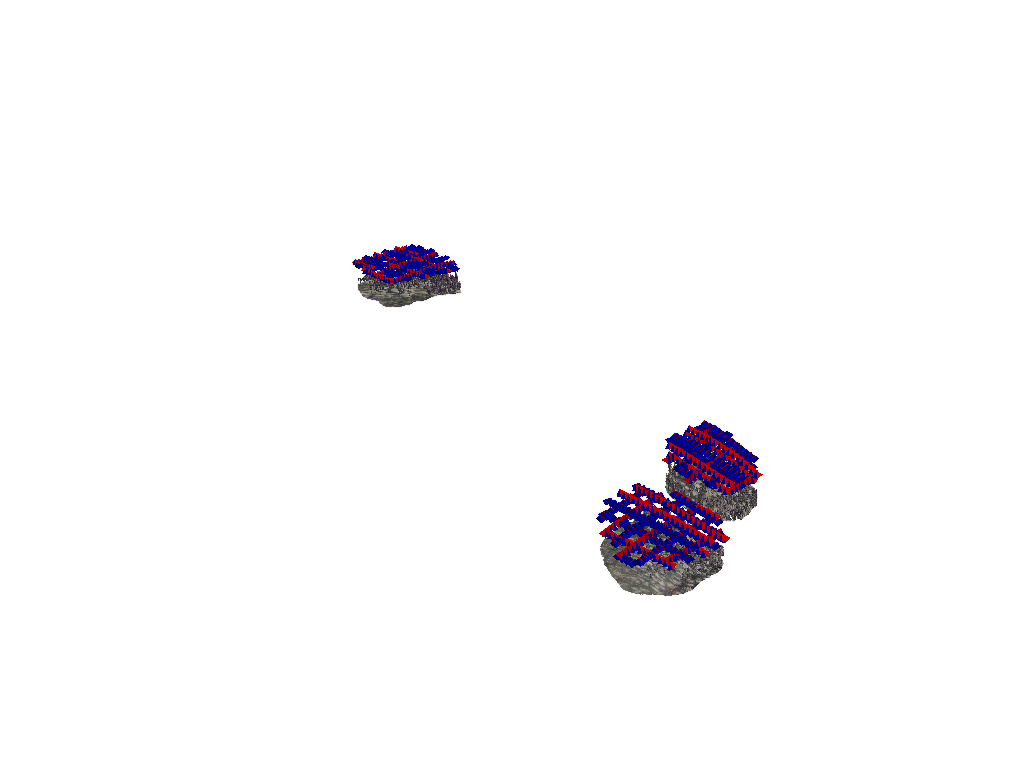

Aggregating information from different viewpoints:   1%|          | 8/708 [00:26<38:12,  3.27s/it]  


KeyboardInterrupt: 

In [13]:
mesh = TexturedPhotogrammetryMesh(
    PREDICTION_MESH_FILENAME,
    transform_filename=PREDICTION_CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
print("Done creating mesh")

# Create camera set
camera_set = MetashapeCameraSet(PREDICTION_CAMERAS_FILENAME, INFERENCE_IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(INFERENCE_IMAGE_FOLDER)
print("About to vis")
# %%
mesh.vis(camera_set=training_camera_set, force_xvfb=True)

# %%
segmentor = LookUpSegmentor(
    base_folder=INFERENCE_IMAGE_FOLDER,
    lookup_folder=PREDICTIONS_FOLDER,
    num_classes=8,
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
    segmentor_camera_set,
    image_scale=AGGREGATE_IMAGE_SCALE,
)

# Export the predictions

In [14]:
# %%
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=PREDICTION_DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)
np.save(NUMPY_EXPORT_FACES_TEXTURE_FILE, predicted_face_classes)
# %%
mesh.vis(
    vis_scalars=predicted_face_classes,
    force_xvfb=True,
)

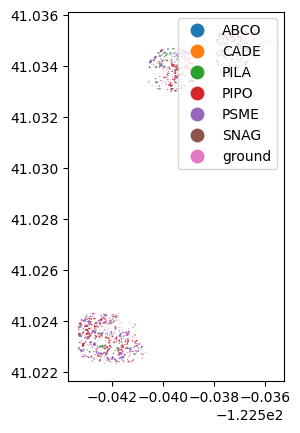

,class_id,geometry,names
0,0.0,"MULTIPOLYGON (((-122.54330 41.02288, -122.5433...",ABCO
1,1.0,"MULTIPOLYGON (((-122.54223 41.02429, -122.5422...",CADE
2,2.0,"MULTIPOLYGON (((-122.54327 41.02339, -122.5432...",PILA
3,3.0,"MULTIPOLYGON (((-122.54331 41.02293, -122.5433...",PIPO
4,4.0,"MULTIPOLYGON (((-122.54331 41.02288, -122.5433...",PSME
5,6.0,"MULTIPOLYGON (((-122.54209 41.02247, -122.5420...",SNAG
6,7.0,"MULTIPOLYGON (((-122.54317 41.02260, -122.5431...",ground


In [14]:
predicted_face_classes = np.load(NUMPY_EXPORT_FACES_TEXTURE_FILE)
mesh.export_face_labels_vector(
   face_labels=np.squeeze(predicted_face_classes),
   export_file=PREDICTED_VECTOR_LABELS_FILE,
   label_names=class_names,
   vis=True,
   vis_kwargs={"cmap": "tab10", "vmin": -0.5, "vmax": 9.5},
)

# Evaluate predictions

,class_id,names,geometry
0,0.0,ABCO,"MULTIPOLYGON (((-122.54330 41.02288, -122.5433..."
1,1.0,CADE,"MULTIPOLYGON (((-122.54223 41.02429, -122.5422..."
2,2.0,PILA,"MULTIPOLYGON (((-122.54327 41.02339, -122.5432..."
3,3.0,PIPO,"MULTIPOLYGON (((-122.54331 41.02293, -122.5433..."
4,4.0,PSME,"MULTIPOLYGON (((-122.54331 41.02288, -122.5433..."
5,6.0,SNAG,"MULTIPOLYGON (((-122.54209 41.02247, -122.5420..."


['ABCO', 'CADE', 'PILA', 'PIPO', 'PSME', 'QUEV', 'SNAG', 'ground']


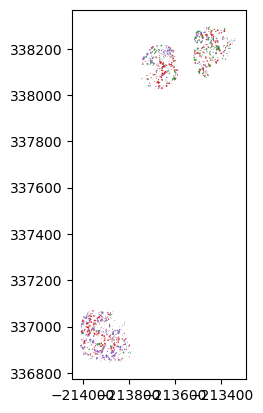

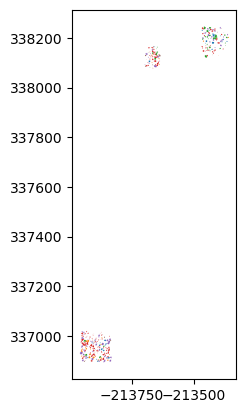

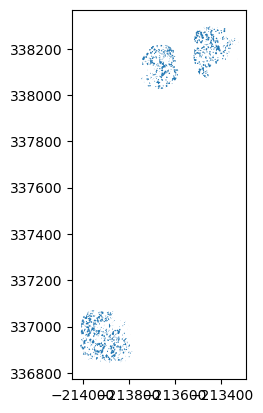

In [17]:
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector
pred_gdf = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
pred_gdf = pred_gdf.query("names != 'ground'")
display(pred_gdf)
print(class_names)
gt_gdf = gpd.read_file(LABELS_FILENAME).query(f"fire=='{short_pred_name}'")
pred_gdf.to_crs(gt_gdf.crs, inplace=True)
pred_gdf.plot("class_id", cmap="tab10",vmin=0, vmax=9)
gt_gdf.plot("species_observed", vmin=0, vmax=9)
counts_mat, inds_into_original = get_overlap_vector(unlabeled_df=gt_gdf, classes_df=pred_gdf, class_column="names")

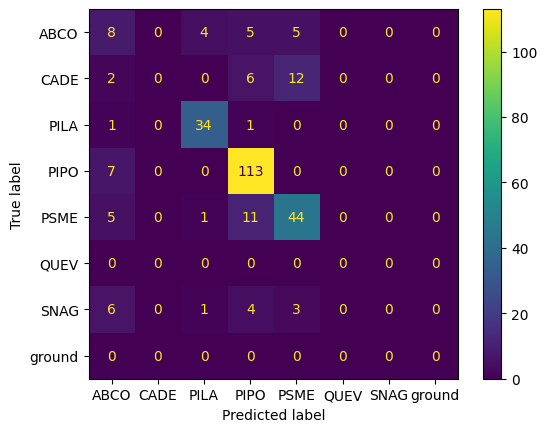

0.7289377289377289


In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

training_gdf = gpd.read_file(LABELS_FILENAME)
labeled_gt_gdf = gt_gdf.iloc[inds_into_original]

pred_class_IDs = np.argmax(counts_mat, axis=1)
pred_class_names = [class_names[ID] for ID in pred_class_IDs]

cf_matrix = confusion_matrix(
    y_true=labeled_gt_gdf["species_observed"].tolist(),
    y_pred=pred_class_names,
    labels=class_names,
)
cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=class_names)
cf_disp.plot()
plt.show()
accuracy = np.sum(cf_matrix * np.eye(cf_matrix.shape[0])) / np.sum(cf_matrix)
print(accuracy)